### 1. Klonowanie repozytorium YOLOv5 oraz instalacja wymaganych przez oprogramowanie bibliotek. 
### Parsowanie adnotacji dla zbioru face-mask-detection z formatu XML do formatu YOLO.
### Tworzenie potrzebnych folderów.

In [1]:
#pobieranie i instalacja potrzebnych bibliotek
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!pip install -qr requirements.txt

from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import xml.etree.ElementTree as ET
import os
import shutil
from sklearn.model_selection import train_test_split
import tqdm

#instalacja oraz logowanie do wandb, należy podać własny kod autoryzacyjny
%pip install -q wandb
import wandb
wandb.login()


#przypisanie klas: with_mash=0, without_mask=1, mask_weared_incorrect=1
CLASSES = ['with_mask', 'without_mask', 'mask_weared_incorrect']

#funkcja normalizująca rozmiar ramki wokół twarzy
def convert_bbox(box, img_size):
    dw = 1. / (img_size[0])
    dh = 1. / (img_size[1])
    x = (box[0] + box[1]) / 2.0
    y = (box[2] + box[3]) / 2.0
    w = box[1] - box[0]
    h = box[3] - box[2]
    x = round(x * dw, 6)
    w = round(w * dw, 6)
    y = round(y * dh, 6)
    h = round(h * dh, 6)
    return (x,y,w,h)

#funkcja przetwarzające adnotacje dla pierwszego zbioru w formacie XML na format txt
def convert_ann(xml_path, yolo_path):
    file_in = open(xml_path, 'r')
    tree = ET.parse(file_in)
    has_label = False
    file_out = open(yolo_path, 'w')
    for ele in tree.iter():
        if 'size' in ele.tag:
            img_w = int(ele.find('width').text)
            img_h = int(ele.find('height').text)
        if 'object' in ele.tag:
            has_label = True
            name = ele.find('name').text
            class_id = CLASSES.index(name)
            xml_box = ele.find('bndbox')
            bbox = (float(xml_box.find('xmin').text),
                    float(xml_box.find('xmax').text),
                    float(xml_box.find('ymin').text),
                    float(xml_box.find('ymax').text))
            bbox = convert_bbox(bbox, (img_w, img_h))
            file_out.write(str(class_id) + ' ' + ' '.join([str(s) for s in bbox]) + '\n')
    if not has_label:
        print(xml_path)
        
    file_in.close()
    file_out.close()

#tworzenie potrzebnych folderow do trenowania/walidacji oraz testowania YOLOv5
!mkdir -p facemask/train/images
!mkdir -p facemask/train/labels
!mkdir -p facemask/val/images
!mkdir -p facemask/val/labels
!mkdir -p facemask/test/images
!mkdir -p facemask/test/labels

#tworzenie folderów dla zdjęć i adnotacji zbioru wspólnego
!mkdir -p facemask_temp/images
!mkdir -p facemask_temp/labels

Cloning into 'yolov5'...
remote: Enumerating objects: 12076, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 12076 (delta 12), reused 12 (delta 3), pack-reused 12047
Receiving objects: 100% (12076/12076), 11.86 MiB | 15.85 MiB/s, done.
Resolving deltas: 100% (8370/8370), done.
/kaggle/working/yolov5
Note: you may need to restart the kernel to use updated packages.


wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


### 2. Przeniesienie plików ze zbiorów danych do jednego wspólnego folderu z którego następnie zostaną rozdzielone na train/val/test sets
### Losowanie oraz podział zdjęć i adnotacji na foldery które zostaną wykorzystane do trenowania, walidacji oraz testowania 

In [2]:
#definicja odpowiednich ścieżek
xml_base = '/kaggle/input/face-mask-detection/annotations'
yolo_base = '/kaggle/working/yolov5/facemask_temp/labels'
img_base = '/kaggle/working/yolov5/facemask_temp/images'


def load_first_dataset():
    #parsowanie plików xml (dla zbioru face-mask-detection) na format yolo 
    #oraz od razu utworzenie ich w odpowiednim folderze
    xml_files = os.listdir(xml_base)
    for xml_file in xml_files:
        yolo_file = xml_file.split('.')[0] + '.txt'
        convert_ann(os.path.join(xml_base, xml_file), os.path.join(yolo_base, yolo_file))
    
    #przenoszenie zdjęć ze zbioru face-mask-detection do wspólnego folderu
    path = '/kaggle/input/face-mask-detection/images'
    for images in os.listdir(path):
        image_path = os.path.join(path,images)
        shutil.copy(image_path,'/kaggle/working/yolov5/facemask_temp/images/'+images)
    print("Dataset nr.1 loaded")
        
def load_background_dataset():
    #przenoszenie zdjęć ze zbioru background do wspólnego folderu
    path = "/kaggle/input/myunder/images/"
    for images in os.listdir(path):
        image_path = os.path.join(path,images)
        shutil.copy(image_path,'/kaggle/working/yolov5/facemask_temp/images/'+images)

    #przenoszenie etykiet ze zbioru background do wspólnego folderu
    path = "/kaggle/input/myunder/bbox_txt/"
    for images in os.listdir(path):
        image_path = os.path.join(path,images)
        shutil.copy(image_path,'/kaggle/working/yolov5/facemask_temp/labels/'+images)
    print("Dataset nr.2 loaded")

def load_incorrect_dataset():
    #przenoszenie zdjęć z dodatkowego zbioru ze źle założonymi maskami do wspólnego folderu
    path = "/kaggle/input/yoloxxx1/images2/"
    for images in os.listdir(path):
        image_path = os.path.join(path,images)
        shutil.copy(image_path,'/kaggle/working/yolov5/facemask_temp/images/'+images)

    #przenoszenie etykiet z dodatkowego zbioru ze źle założonymi maskami do wspólnego folderu    
    path = "/kaggle/input/yoloxxx1/bbox_txt/"
    for images in os.listdir(path):
        image_path = os.path.join(path,images)
        shutil.copy(image_path,'/kaggle/working/yolov5/facemask_temp/labels/'+images)
    print("Dataset nr.3 loaded")

def load_without_mask_dataset():
    #przenoszenie zdjęć ze zbioru ludźi bez założonych maseczek do wspólnego folderu
    path = "/kaggle/input/yoloxxx2/images/"
    for images in os.listdir(path):
        image_path = os.path.join(path,images)
        shutil.copy(image_path,'/kaggle/working/yolov5/facemask_temp/images/'+images)

    #przenoszenie etykiet ze zbioru ludźi bez założonych maseczek do wspólnego folderu
    path = "/kaggle/input/yoloxxx2/bbox_txt/"
    for images in os.listdir(path):
        image_path = os.path.join(path,images)
        shutil.copy(image_path,'/kaggle/working/yolov5/facemask_temp/labels/'+images)
    print("Dataset nr.4 loaded")

### 3. Rozdzielenie plików na foldery 

In [3]:
#mieszanie oraz przeniesienie plików ze zdjęciami oraz adnotacjami (etykietami) do odpowiednich folderów
def move_files_to_train_val_test_dirs():
    def help_move_files(files, type='train'):
        for file in tqdm.tqdm(files):
            img_src = os.path.join(img_base, file)
            ann_src = os.path.join(yolo_base, file.split('.')[0] + '.txt')
            img_dst = 'facemask/' + type +'/images/' + file
            ann_dst = 'facemask/' + type +'/labels/' + file.split('.')[0] + '.txt'
            shutil.copy(img_src, img_dst)
            shutil.copy(ann_src, ann_dst)
        print('Complete move', type, 'files')
    #wylosowanie listy plików dla ze wspólnego zbioru na zbiory treningowy, walidacyjny i testowy
    all_files = os.listdir("/kaggle/working/yolov5/facemask_temp/images")
    train_files, test_files = train_test_split(all_files, test_size=0.4, random_state=303)
    val_files, test_files =  train_test_split(test_files, test_size=0.5, random_state=303)
    print('Train files:', len(train_files))
    print('Val files:', len(val_files))
    print('Test files:', len(test_files))
    help_move_files(train_files, 'train')
    help_move_files(test_files, 'test')
    help_move_files(val_files, 'val')

### 4. Tworzenie rysunków charakteryzujących zbiór danych

In [4]:
#stworzenie rysunków rozkładu danych w zbiorach
def check_dataset_distr(path):
    lista=os.listdir(path)
    count_mask = 0
    count_without_mask = 0
    count_incorrect_mask = 0
    count_background=0
    for i in lista:
        blokada=0
        with open(path+i) as fp:
            while True:
                line = fp.readline()
                if not line:
                    if blokada==0:
                        count_background += 1
                    break
                blokada=1
                if int(line.strip()[0])==0:
                    count_mask += 1
                elif int(line.strip()[0])==1:
                    count_without_mask += 1
                elif int(line.strip()[0])==2:
                    count_incorrect_mask += 1
                else:
                    break
    print("Z maską:",count_mask)
    print("Bez maski:",count_without_mask)
    print("Niepoprawnie założona:",count_incorrect_mask)
    print("Zdjęcia samego tła:", count_background)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(14,6))
    background_color = '#faf9f4'
    ax1.set_facecolor(background_color)
    ax2.set_facecolor(background_color) 
    ax1.pie([count_mask,count_without_mask,count_incorrect_mask, count_background],wedgeprops=dict(width=0.3, edgecolor='w') ,
            labels=['count_mask','count_without_mask','count_incorrect_mask', "background"], radius=1, startangle = 120, autopct='%1.2f%%')

    ax2 = plt.bar(['count_mask','count_without_mask','count_incorrect_mask', 'background'], [count_mask,count_without_mask,count_incorrect_mask, count_background],
                  color ='maroon',width = 0.5)
    plt.show()

### 5. Ustawianie modelu

In [5]:
def create_yolo_data_settings_files():
    #przygotowanie pliku facemask.yaml ze zbiorami do trenowania i walidacji
    #oraz zapisanie do niego liczby klas i przypisanie klasom odpowiednich etykiet
    # with_mask = 0, without_mask = 1, incorrect_mask = 2
    yaml_text = """train: facemask/train/images
val: facemask/val/images

nc: 3
names: ['with_mask', 'without_mask', 'incorrect_mask']"""

    #zapis do pliku
    with open("facemask.yaml", 'w') as f:
        f.write(yaml_text)

    #przygotowanie pliku dla zbioru testowego
    yaml_test_text = """train: facemask/train/images
val: facemask/test/images

nc: 3
names: ['with_mask', 'without_mask', 'incorrect_mask']"""

    #zapis do pliku
    with open("facemask_test.yaml", 'w') as f:
        f.write(yaml_test_text)

### 4. Trening modelu wykorzystując transfer-learning (pretrained weights) 

In [6]:
#rozpoczęcie treningu, 300 epok, batch_size 32, zbiory z pliku facemask, wagi z pliku yolov5n.pt - przetrenowany wcześniej model przez twórców oprogramowania na zbiorze COCO, device 0 (karta graficzna), project - nazwa projektu do wandb
#name - nazwa instancji w projekcie, patience 30 - po ilu epokach pod rząd bez progresu przerwać trening
#możliwe wersje wag: yolov5n, yolov5s, yolov5m, yolov5l, yolov5x(największa, niewykorzystywana przez nas ze względu na brak zasobów sprzętowych)

def train_model(size, project_name, instance_name, datasets):
    if datasets=="1":
        load_first_dataset()
    elif datasets=="1+2":
        load_first_dataset()
        load_background_dataset()
    elif datasets=="1+2+3+4":
        load_first_dataset()
        load_background_dataset()
        load_incorrect_dataset()
        load_without_mask_dataset()
    else:
        print("Błąd wyboru zbiorów danych")
        return
    #Przeniesienie plików z folderu głównego do 
    move_files_to_train_val_test_dirs()
    
    if size=="nano":
        start = datetime.now()
        !python train.py --img 640 --batch 32 --epochs 10 --data facemask.yaml --weights yolov5n.pt --patience 30 --project project_name --name instance_name --device 0
        end = datetime.now()
        print('Trainine time:', end - start)
    elif size=="small":
        start = datetime.now()
        !python train.py --img 640 --batch 32 --epochs 10 --data facemask.yaml --weights yolov5s.pt --patience 30 --project project_name --name instance_name --device 0
        end = datetime.now()
        print('Trainine time:', end - start)
    elif size=="medium":
        start = datetime.now()
        !python train.py --img 640 --batch 32 --epochs 10 --data facemask.yaml --weights yolov5m.pt --patience 30 --project project_name --name instance_name --device 0
        end = datetime.now()
        print('Trainine time:', end - start)
    elif size=="large":
        start = datetime.now()
        !python train.py --img 640 --batch 32 --epochs 10 --data facemask.yaml --weights yolov5l.pt --patience 30 --project project_name --name instance_name --device 0
        end = datetime.now()
        print('Trainine time:', end - start)
    else:
        print("Błąd wyboru wersji YOLO.")
        return

### 5. Testowanie działania

In [7]:
#łączenie się z naszym projektem w celu pobrania najlepszego stworzonego modelu
def load_the_best_students_model():
    run = wandb.init()
    artifact = run.use_artifact('michael123/YOLOmichaltest/run_1duzjlum_model:v0', type='model')
    artifact_dir = artifact.download()

In [8]:
###########################################################################################
# KOMÓRKA ODPOWIEDZIALNA ZA UŻYCIE WSZYSTKICH NAJWAŻNIEJSZYCH FUNKCJI I START TRENINGU
###########################################################################################

#Utworzenie plików konfiguracyjnych dla YOLO
create_yolo_data_settings_files()

#rozpoczecie treningu
train_model(size="medium", project_name="Test1", instance_name="TestInstance1", datasets="1+2+3+4")

Dataset nr.1 loaded
Dataset nr.2 loaded
Dataset nr.3 loaded
Dataset nr.4 loaded
Train files: 1397
Val files: 466
Test files: 466


100%|██████████| 1397/1397 [00:00<00:00, 1854.58it/s]


Complete move train files


100%|██████████| 466/466 [00:00<00:00, 1962.16it/s]


Complete move test files


100%|██████████| 466/466 [00:00<00:00, 1971.34it/s]


Complete move val files
wandb: Currently logged in as: michael123 (use `wandb login --relogin` to force relogin)
train: weights=yolov5m.pt, cfg=, data=facemask.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=10, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=0, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=project_name, name=instance_name, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=30, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.1-230-gbf1a6dd Python-3.7.12 torch-1.9.1 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, bo

Cały zbiór danych

Z maską: 3406
Bez maski: 1867
Niepoprawnie założona: 1124
Zdjęcia samego tła: 237


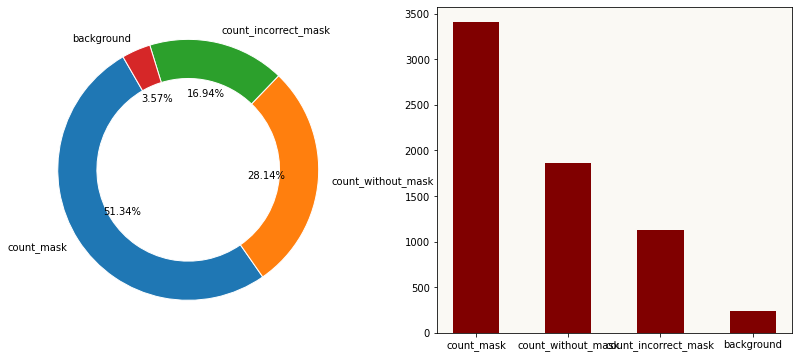

Treningowy zbiór danych

Z maską: 2179
Bez maski: 1110
Niepoprawnie założona: 661
Zdjęcia samego tła: 138


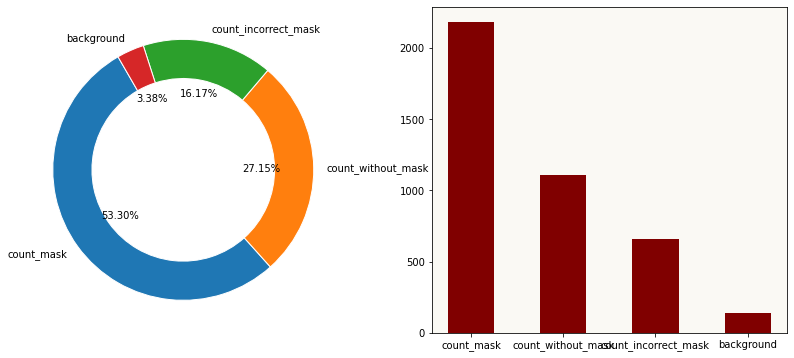

Walidacyjny zbiór danych

Z maską: 498
Bez maski: 360
Niepoprawnie założona: 236
Zdjęcia samego tła: 53


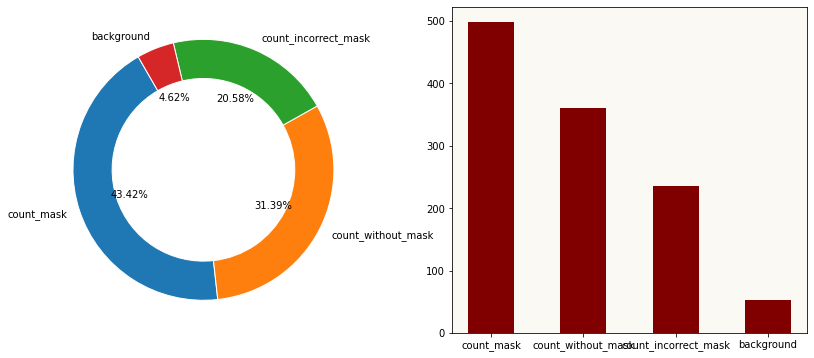

Testowy zbiór danych

Z maską: 729
Bez maski: 397
Niepoprawnie założona: 227
Zdjęcia samego tła: 46


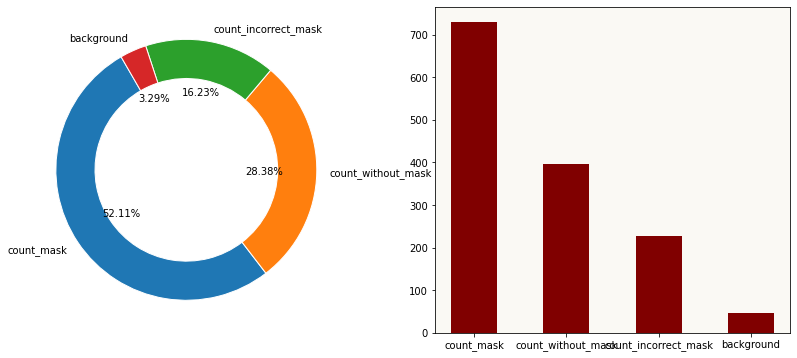

In [9]:
#Wyświetlenie proporcji klas w zbiorze głównym train/val/test dla wybranego datasetu
print("Cały zbiór danych\n")
check_dataset_distr("/kaggle/working/yolov5/facemask_temp/labels/")
print("Treningowy zbiór danych\n")
check_dataset_distr("/kaggle/working/yolov5/facemask/train/labels/")
print("Walidacyjny zbiór danych\n")
check_dataset_distr("/kaggle/working/yolov5/facemask/val/labels/")
print("Testowy zbiór danych\n")
check_dataset_distr("/kaggle/working/yolov5/facemask/test/labels/")

In [10]:
#Załaduj najlepszy model z platformy wandb.ai
load_the_best_students_model()

wandb: Currently logged in as: michael123 (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.17 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [11]:
#zmienna pomocnicza do wyświetlania zdjęć
number_of_file = 1
#definicja funkcji do wyświetlania zdjęć
def show_images(path, num=5):
    cnt = 0
    for file in os.listdir(path):
        img = plt.imread(os.path.join(path, file))
        plt.figure(figsize=(10, 10))
        plt.imshow(img)
        if cnt == num:
            break
        plt.xticks([])
        plt.yticks([])
        plt.show()
        cnt += 1
def show_picture(number_of_file):
    #pokazywanie zdjęć z ramkami wokół twarzy, dla 2 pokazania należy zmienic exp->exp2, dla 3 exp2->exp3 itd.
    if number_of_file==1:
        show_images('runs/detect/exp')
    else:
        show_images('runs/detect/exp'+str(number_of_file))

detect: weights=['project_name/instance_name/weights/best.pt'], source=https://i.ibb.co/cttx6Nr/a5.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=1, hide_labels=False, hide_conf=False, half=False, dnn=False
100%|█████████████████████████████████████████| 126k/126k [00:00<00:00, 467kB/s]
YOLOv5 🚀 v6.1-230-gbf1a6dd Python-3.7.12 torch-1.9.1 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
Model summary: 290 layers, 20861016 parameters, 0 gradients, 48.0 GFLOPs
image 1/1 /kaggle/working/yolov5/a5.jpg: 480x640 2 with_masks, Done. (0.015s)
Speed: 0.5ms pre-process, 14.6ms inference, 1.4ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp


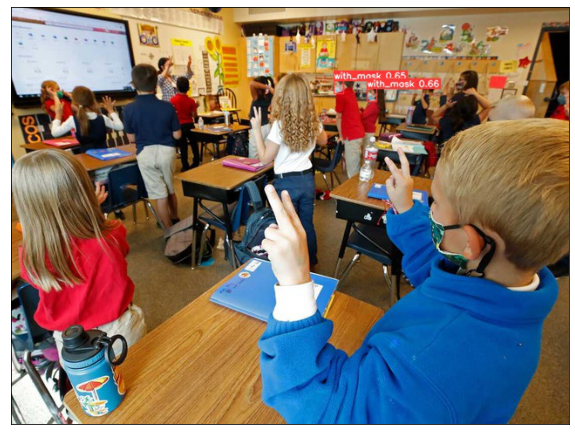

In [12]:
#Wykorzystanie modelu po treningu do detekcji ludzi w maskach/bez masek/niepoprawnie założonych maskach na zdjęciu
!python detect.py --source "https://i.ibb.co/cttx6Nr/a5.jpg" --weight project_name/instance_name/weights/best.pt --img 640 --conf 0.5 --line-thickness 1
show_picture(number_of_file)
number_of_file+=1

detect: weights=['artifacts/run_1duzjlum_model:v0/best.pt'], source=https://i.ibb.co/cyjP2F3/a4.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=1, hide_labels=False, hide_conf=False, half=False, dnn=False
100%|███████████████████████████████████████| 67.5k/67.5k [00:00<00:00, 415kB/s]
YOLOv5 🚀 v6.1-230-gbf1a6dd Python-3.7.12 torch-1.9.1 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
Model summary: 290 layers, 20861016 parameters, 0 gradients, 48.0 GFLOPs
image 1/1 /kaggle/working/yolov5/a4.jpg: 352x640 1 with_mask, 1 without_mask, 1 incorrect_mask, Done. (0.013s)
Speed: 0.4ms pre-process, 13.3ms inference, 1.4ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp2


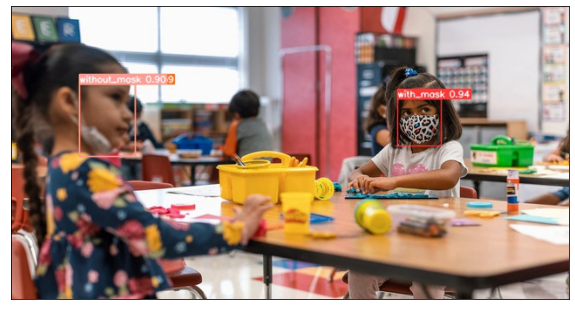

In [13]:
#Wykorzystanie najlepszego wytrenowanego wcześniej modelu z platformy wandb.ai (z naszego projektu) do detekcji ludzi w maskach/bez masek/niepoprawnie założonych maskach na zdjęciu
!python detect.py --source "https://i.ibb.co/cyjP2F3/a4.jpg" --weight artifacts/run_1duzjlum_model:v0/best.pt --img 640 --conf 0.5 --line-thickness 1
show_picture(number_of_file)
number_of_file+=1

In [14]:
#Wykorzystanie najlepszego wytrenowanego wcześniej modelu z platformy wandb.ai (z naszego projektu) do detekcji ludzi w maskach/bez masek/niepoprawnie założonych maskach na filmie z youtube
#Niestety ta opcja nie działa na kaggle, działanie zostanie zaprezentowane podczas rozmowy na teams, z własnego sprzętu, dla kamery --source 0
#!python detect.py --source "https://www.youtube.com/watch?v=tGkhfd2PuAY" --weight artifacts/run_1duzjlum_model:v0/best.pt --img 640 --conf 0.5 --line-thickness 1 

In [15]:
#wyliczenie parametrow dla zbioru testowego za pomocą najlepszego wytrenowanego wcześniej modelu z platformy wandb.ai (z naszego projektu)
!python val.py --data facemask_test.yaml --weights artifacts/run_1duzjlum_model:v0/best.pt --img 640

val: data=facemask_test.yaml, weights=['artifacts/run_1duzjlum_model:v0/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v6.1-230-gbf1a6dd Python-3.7.12 torch-1.9.1 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
Model summary: 290 layers, 20861016 parameters, 0 gradients, 48.0 GFLOPs
val: Scanning '/kaggle/working/yolov5/facemask/test/labels' images and labels...
val: New cache created: /kaggle/working/yolov5/facemask/test/labels.cache
               Class     Images     Labels          P          R     mAP@.5 mAP@
                 all        466       1352      0.969      0.937      0.961      0.787
           with_mask        466        729      0.973      0.968      0.982      0.817
        without_mask        466        396       0

In [16]:
#wyliczenie parametrow dla zbioru testowego za pomocą wytrenowanego modelu w tej sesji
!python val.py --data facemask_test.yaml --weights project_name/instance_name/weights/best.pt --img 640

val: data=facemask_test.yaml, weights=['project_name/instance_name/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v6.1-230-gbf1a6dd Python-3.7.12 torch-1.9.1 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
Model summary: 290 layers, 20861016 parameters, 0 gradients, 48.0 GFLOPs
val: Scanning '/kaggle/working/yolov5/facemask/test/labels.cache' images and lab
               Class     Images     Labels          P          R     mAP@.5 mAP@
                 all        466       1353      0.888       0.87      0.914      0.591
           with_mask        466        729      0.836      0.934      0.947       0.62
        without_mask        466        397      0.846      0.768      0.842      0.458
      incorrect_mask        466   